In [94]:
import sys
if "../" not in sys.path: sys.path.append("../")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from os import path
import tempfile
import imageio
import cv2
import h5py

from tqdm.notebook import tqdm

# import seaborn as sns
# sns.set(rc={'figure.facecolor':'white'})
# plt.rcParams["figure.facecolor"] = "white"

%matplotlib inline

from analysis_helpers import savefig, load_data_by_session_id, set_major_minor_ticks, load_additional_data

from eye_tracking.eye_tracking import get_stim_at_frame, get_saccade_magnitude_direction
from experiment.cre_line import match_cre_line
from eye_plotting import STIM_ABBREV, STIM_COLORS

from saccade_config import *

In [13]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
boc = BrainObservatoryCache(manifest_file=BRAIN_OBSERVATORY_CACHE_MANIFEST_FILE)

In [162]:
df_cells = pd.read_csv(LOADED_CLASSIFIED_CELLS_CSV)
df_cells.set_index("specimen_id", inplace=True)
df_cells.head()

,cre_line,cre_abbrev,depth,targeted_structure,container_id,session_indices,response_classification,p_value,n_left,n_right,mean_left_response,mean_right_response,median_left_response,median_right_response,direction_selectivity,frac_left_significant,frac_right_significant,wilcoxon_signed_rank_p,ranksum_p_by_direction
specimen_id,,,,,,,,,,,,,,,,,,,
589170196,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2; Ai93,175.0,VISp,511510718.0,"((510174759, 11), (510345479, 67), (510514474,...",0.0,0.148500,25.0,36.0,-0.005011,0.028588,-0.003895,-0.000737,1.425049,0.20,0.138889,0.378918,0.311603
517424547,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2; Ai93,175.0,VISp,511510718.0,"((510174759, 109), (510345479, 68), (510514474...",0.0,0.849025,25.0,36.0,-0.008454,-0.002251,-0.013324,0.000459,-0.579440,0.20,0.166667,0.489899,0.472405
589170394,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2; Ai93,175.0,VISp,511510718.0,"((510174759, 27), (510345479, 205), (510514474...",0.0,0.994925,25.0,36.0,-0.084782,-0.060959,-0.033635,0.006427,-0.163455,0.20,0.277778,0.245655,0.018225
589170745,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2; Ai93,175.0,VISp,511510718.0,"((510174759, 6), (510345479, 206), (510514474,...",0.0,0.018600,25.0,36.0,0.133313,0.303742,-0.005347,0.017718,0.389949,0.24,0.194444,0.301768,0.713904
589170856,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2; Ai93,175.0,VISp,511510718.0,"((510174759, 9), (510345479, 22), (510514474, 9))",0.0,0.231125,25.0,36.0,-0.013324,0.014109,-0.006405,0.009928,34.951378,0.24,0.222222,0.893064,0.012153


In [163]:
file_locations_df = pd.read_csv("/Users/chase/Desktop/MindScope/eye_data/data_info.csv")
file_locations_df.set_index("session_id", inplace=True)
file_locations_df.head()

,container_id,targeted_structure,cre_line,session_type,published_at,eye_video_file,eye_tracking_file,time_sync_file,allen_eye_video_file,allen_eye_tracking_file,allen_time_sync_file,allen_eye_video_file_mac,allen_eye_tracking_file_mac,allen_time_sync_file_mac
session_id,,,,,,,,,,,,,,
649409874,646959440,VISpm,Vip-IRES-Cre,three_session_A,2018-10-04,649381281_350249_20171120124228_video-1.avi,649381281_eyetracking_dlc_to_screen_mapping.h5,649409874_time_synchronization.h5,\\allen\programs\braintv\production\neuralcodi...,\\allen\programs\braintv\production\neuralcodi...,\Volumes\programs\braintv\production\neuralcod...,/Volumes/programs/braintv/production/neuralcod...,/Volumes/programs/braintv/production/neuralcod...,/Volumes/programs/braintv/production/neuralcod...
663488086,662358769,VISl,Slc17a7-IRES2-Cre,three_session_B,2018-10-04,663353237_361636_20180213123907_video-1.avi,663353237_eyetracking_dlc_to_screen_mapping.h5,663488086_time_synchronization.h5,\\allen\programs\braintv\production\neuralcodi...,\\allen\programs\braintv\production\neuralcodi...,\Volumes\programs\braintv\production\neuralcod...,/Volumes/programs/braintv/production/neuralcod...,/Volumes/programs/braintv/production/neuralcod...,/Volumes/programs/braintv/production/neuralcod...
604328043,604328040,VISrl,Slc17a7-IRES2-Cre,three_session_A,2018-10-04,604328043_325932_20170726_video-1.avi,610507324_eyetracking_dlc_to_screen_mapping.h5,604328043_time_synchronization.h5,\\allen\programs\braintv\production\neuralcodi...,\\allen\programs\braintv\production\neuralcodi...,\Volumes\programs\braintv\production\neuralcod...,/Volumes/programs/braintv/production/neuralcod...,/Volumes/programs/braintv/production/neuralcod...,/Volumes/programs/braintv/production/neuralcod...
577225417,575772104,VISl,Vip-IRES-Cre,three_session_C2,2018-10-04,577225417_296710_20170328_video-1.avi,610502115_eyetracking_dlc_to_screen_mapping.h5,577225417_time_synchronization.h5,\\allen\programs\braintv\production\neuralcodi...,\\allen\programs\braintv\production\neuralcodi...,\Volumes\programs\braintv\production\neuralcod...,/Volumes/programs/braintv/production/neuralcod...,/Volumes/programs/braintv/production/neuralcod...,/Volumes/programs/braintv/production/neuralcod...
627823695,627823692,VISp,Ntsr1-Cre_GN220,three_session_A,2018-10-04,626123869_339814_20170914_video-1.avi,626123869_eyetracking_dlc_to_screen_mapping.h5,627823695_time_synchronization.h5,\\allen\programs\braintv\production\neuralcodi...,\\allen\programs\braintv\production\neuralcodi...,\Volumes\programs\braintv\production\neuralcod...,/Volumes/programs/braintv/production/neuralcod...,/Volumes/programs/braintv/production/neuralcod...,/Volumes/programs/braintv/production/neuralcod...


In [165]:
session_id = 606227591
row = file_locations_df.loc[session_id]
print("Allen video file location:")
print(row["allen_eye_video_file_mac"])
row

Allen video file location:
/Volumes/programs/braintv/production/neuralcoding/prod28/specimen_593402247/ophys_experiment_606227591/606227591_323984_20170803_video-1.avi


container_id                                                           603425700
targeted_structure                                                          VISp
cre_line                                                         Ntsr1-Cre_GN220
session_type                                                    three_session_C2
published_at                                                          2018-10-04
eye_video_file                             606227591_323984_20170803_video-1.avi
eye_tracking_file                 610507864_eyetracking_dlc_to_screen_mapping.h5
time_sync_file                                 606227591_time_synchronization.h5
allen_eye_video_file           \\allen\programs\braintv\production\neuralcodi...
allen_eye_tracking_file        \\allen\programs\braintv\production\neuralcodi...
allen_time_sync_file           \Volumes\programs\braintv\production\neuralcod...
allen_eye_video_file_mac       /Volumes/programs/braintv/production/neuralcod...
allen_eye_tracking_file_mac 

In [134]:
local_eye_data = "/Users/chase/Desktop/MindScope/eye_data"
local_eye_files = {
    606227591: ("/Users/chase/Desktop/eye_tracking_vids/606227591_323984_20170803_video-1.avi", path.join(local_eye_data, "606227591_time_synchronization.h5")),
}

In [127]:
data = load_data_by_session_id(session_id)

print(len(data["saccades"]))
data["session_data"]

218


{'session_id': 606227591,
 'container_id': 603425700,
 'session_type': 'three_session_C2',
 'cre_line': 'Ntsr1-Cre_GN220; Ai148(TIT2L-GC6f-ICL-tTA2)',
 'cre_abbrev': 'Ntsr1; Ai148',
 'targeted_structure': 'VISp'}

In [ ]:
data

<AxesSubplot:>

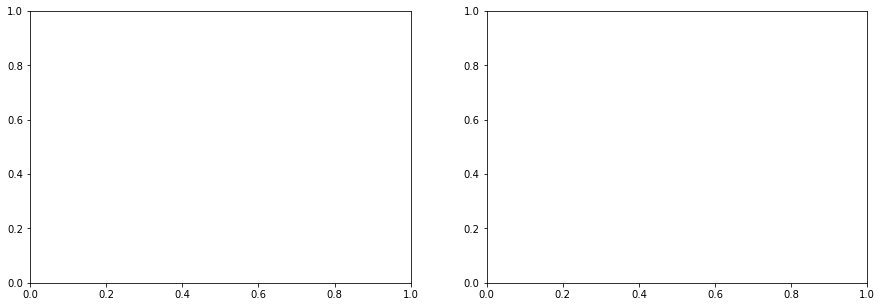

In [12]:
# print(data["saccades"])

start = 10950
end = start + 7*30

fig, axs = plt.subplots(figsize=(15, 5), ncols=2, facecolor="white")

ax = axs[0]


In [158]:
ophys_data = boc.get_ophys_experiment_data(session_id)
roi_masks = ophys_data.get_roi_mask_array()
roi_pixels = np.argwhere(roi_masks)

timestamps, dff = ophys_data.get_dff_traces()
n_rois = len(dff)
print(dff.shape)

gif_file_name = "/Users/chase/Desktop/test.gif"
eye_movie_file, time_sync_file = local_eye_files[session_id]
eye_movie = cv2.VideoCapture(eye_movie_file)

n_frames_total = int(eye_movie.get(cv2.CAP_PROP_FRAME_COUNT)) # total frames in video
width = int(eye_movie.get(cv2.CAP_PROP_FRAME_WIDTH)) # video width
height = int(eye_movie.get(cv2.CAP_PROP_FRAME_HEIGHT)) # video heights
print(f"Video has {n_frames_total} total frames ({width} x {height})")

with h5py.File(time_sync_file, mode="r") as time_sync:
    twop_frame_to_vid_frame = time_sync["eye_tracking_alignment"][()].astype(int)

start_frame = 7590
end_frame = start_frame + 10*30

# vmin = np.quantile(dff[:, start_frame:end_frame], 0.01)
vmin = 0
vmax = np.quantile(dff[:, start_frame:end_frame], 0.99)
print("vmin, vmax =", vmin, vmax)

# frame_offset = n_frames_total - dff.shape[1]
print(n_frames_total - dff.shape[1])
frame_offset = 0

eye_tracking = data["eye_tracking"]

with tempfile.TemporaryDirectory() as gif_dir:
    print("Temp dir", gif_dir)
    gif_files = []
    fig = plt.figure(figsize=(20, 10), facecolor="white")
    ax_roi = fig.add_subplot(2, 2, 1)
    ax_eyevid = fig.add_subplot(2, 2, 2)
    ax_eyetrace = fig.add_subplot(2, 1, 2)

    ax_eyetrace.plot(eye_tracking.x_pos_deg.loc[start:end], label="x")
    ax_eyetrace.plot(eye_tracking.x_pos_deg.loc[start:end], label="y")
    frame_line = ax_eyetrace.axvline(x=1, color="black", linestyle="dotted")
    ax_eyetrace.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc="upper left", bbox_transform=ax_eyetrace.transAxes)

    roi_activity = np.nan * np.zeros(roi_masks.shape[1:])
    cbar = None

    for image_i, frame in enumerate(tqdm(range(start_frame, end_frame))):
        # (1) ROI activity heatmap
        ax_roi.clear()
        
        for roi in range(n_rois):
            value = dff[roi, frame]
            for i, j in roi_pixels[roi_pixels[:, 0] == roi][:, 1:]:
                if np.isnan(roi_activity[i, j]) or value > roi_activity[i, j]:
                    roi_activity[i, j] = value
        
        im = ax_roi.imshow(roi_activity, cmap="hot", vmin=vmin, vmax=vmax)
        
        if cbar is None:
            cbar = fig.colorbar(im, ax=ax_roi)
            cbar.set_label("dF/F", fontsize=14)
            cbar.ax.tick_params(labelsize=14)
            # ax.axis("off")
            ax_roi.xaxis.set_visible(False)
            ax_roi.yaxis.set_visible(False)
        
        # (2) Eye video
        ax_eyevid.clear()
        vid_frame = twop_frame_to_vid_frame[frame]
        eye_movie.set(cv2.CAP_PROP_POS_FRAMES, vid_frame-1)
        flag, image = eye_movie.read()
        ax_eyevid.imshow(image)
        
        # (3) Eye trace
        frame_line.set_xdata([frame, frame])

        # Save figure
        fig.suptitle(f"Frame {frame}", fontsize=14)
        # fig.canvas.draw()
        fig.tight_layout()
        filename = path.join(gif_dir, f"{image_i}.png")
        gif_files.append(filename)
        fig.savefig(filename)
    
    plt.close(fig)
    fig = None
    ax = None
    
    # imageio.imsave(exportname, frames, format="GIF", fps=30)

    with imageio.get_writer(gif_file_name, mode="I", fps=30) as writer: # format="GIF"
        for file in gif_files:
            image = imageio.imread(file)
            writer.append_data(image)

# overlay_mask = dataset.get_roi_mask()[0].get_mask_plane().astype(float)
# overlay_mask[overlay_mask == 0] = np.nan
# plt.imshow(dataset.get_max_projection(), cmap='gray')
# plt.imshow(overlay_mask, cmap=overlay_map, alpha=0.3)


(41, 124047)
Video has 124185 total frames (640 x 480)
vmin, vmax = 0 0.19390557020902635
138
Temp dir /var/folders/8l/944wpj6s7sq8gcv57wcd3q6h0000gn/T/tmp955wcx71


  0%|          | 0/300 [00:00<?, ?it/s]

/opt/anaconda3/envs/mindscope/lib/python3.7/site-packages/ipykernel_launcher.py:70: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


In [157]:
start_frame = 7590
end_frame = start_frame + 10*30
np.quantile(dff[:, start_frame:end_frame], 0.99)

0.19390557020902635

In [153]:
eye_movie_file, time_sync_file = local_eye_files[session_id]
print(time_sync_file)

    # for twop_frame, eyevid_frame in enumerate(eye_tracking_alignment):
# 


/Users/chase/Desktop/MindScope/eye_data/606227591_time_synchronization.h5
1    122731
0       812
2       503
dtype: int64


Text(0, 0.5, 'degrees')

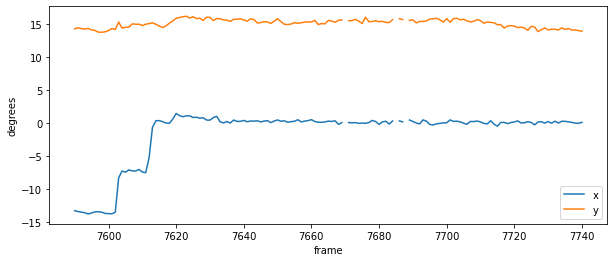

In [119]:
fig, ax = plt.subplots(figsize=(10, 4), facecolor="white")

start = 7590
end = start + 30*5
eye_tracking = data["eye_tracking"]
ax.plot(eye_tracking.x_pos_deg.loc[start:end], label="x")
ax.plot(eye_tracking.y_pos_deg.loc[start:end], label="y")
ax.legend()
ax.set_xlabel("frame")
ax.set_ylabel("degrees")

In [122]:
dff.shape, eye_tracking.frame

((41, 124047),
 frame
 0              0
 1              1
 2              2
 3              3
 4              4
            ...  
 124042    124042
 124043    124043
 124044    124044
 124045    124045
 124046    124046
 Name: frame, Length: 124047, dtype: int64)

In [207]:
ophys_data = boc.get_ophys_experiment_data(session_id)
roi_masks = ophys_data.get_roi_mask_array()
roi_pixels = np.argwhere(roi_masks)

timestamps, dff = ophys_data.get_dff_traces()
n_rois = len(dff)
print(dff.shape)

gif_file_name = "/Users/chase/Desktop/test.gif"
eye_movie_file, time_sync_file = local_eye_files[session_id]
eye_movie = cv2.VideoCapture(eye_movie_file)

n_frames_total = int(eye_movie.get(cv2.CAP_PROP_FRAME_COUNT)) # total frames in video
width = int(eye_movie.get(cv2.CAP_PROP_FRAME_WIDTH)) # video width
height = int(eye_movie.get(cv2.CAP_PROP_FRAME_HEIGHT)) # video heights
print(f"Video has {n_frames_total} total frames ({width} x {height})")

with h5py.File(time_sync_file, mode="r") as time_sync:
    twop_frame_to_vid_frame = time_sync["eye_tracking_alignment"][()].astype(int)

start_frame = 7590
end_frame = start_frame + 10*30

frames_to_plot = []

for ss, se in data["saccades"]:
    mag, dir = get_saccade_magnitude_direction(data["eye_tracking"], ss, se)
    if dir == "L":
        for f in range(ss-10, ss+10):
            frames_to_plot.append(f)

    if len(frames_to_plot) > 120:
        break

print(frames_to_plot)

# vmin = np.quantile(dff[:, start_frame:end_frame], 0.01)
vmin = 0
# vmax = np.quantile(dff[:, start_frame:end_frame], 0.99)
vmax = 0.4
print("vmin, vmax =", vmin, vmax)

# frame_offset = n_frames_total - dff.shape[1]
print(n_frames_total - dff.shape[1])
frame_offset = 0

eye_tracking = data["eye_tracking"]

with tempfile.TemporaryDirectory() as gif_dir:
    print("Temp dir", gif_dir)
    gif_files = []
    fig = plt.figure(figsize=(20, 10), facecolor="white")
    ax_roi = fig.add_subplot(2, 2, 1)
    ax_eyevid = fig.add_subplot(2, 2, 2)
    ax_eyetrace = fig.add_subplot(2, 1, 2)

    ax_eyetrace.plot(eye_tracking.x_pos_deg.loc[start:end], label="x")
    ax_eyetrace.plot(eye_tracking.x_pos_deg.loc[start:end], label="y")
    frame_line = ax_eyetrace.axvline(x=1, color="black", linestyle="dotted")
    ax_eyetrace.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc="upper left", bbox_transform=ax_eyetrace.transAxes)

    roi_activity = np.nan * np.zeros(roi_masks.shape[1:])
    cbar = None

    for image_i, frame in enumerate(tqdm(frames_to_plot)):
        # (1) ROI activity heatmap
        ax_roi.clear()
        
        for roi in range(n_rois):
            value = dff[roi, frame]
            for i, j in roi_pixels[roi_pixels[:, 0] == roi][:, 1:]:
                if np.isnan(roi_activity[i, j]) or value > roi_activity[i, j]:
                    roi_activity[i, j] = value
        
        im = ax_roi.imshow(roi_activity, cmap="hot", vmin=vmin, vmax=vmax)
        
        if cbar is None:
            cbar = fig.colorbar(im, ax=ax_roi)
            cbar.set_label("dF/F", fontsize=14)
            cbar.ax.tick_params(labelsize=14)
            # ax.axis("off")
            ax_roi.xaxis.set_visible(False)
            ax_roi.yaxis.set_visible(False)
        
        # (2) Eye video
        ax_eyevid.clear()
        vid_frame = twop_frame_to_vid_frame[frame]
        eye_movie.set(cv2.CAP_PROP_POS_FRAMES, vid_frame-1)
        flag, image = eye_movie.read()
        ax_eyevid.imshow(image)
        
        # (3) Eye trace
        # frame_line.set_xdata([frame, frame])
        # ax_eyetrace.set_xlim()

        # Save figure
        fig.suptitle(f"Frame {frame}", fontsize=14)
        # fig.canvas.draw()
        fig.tight_layout()
        filename = path.join(gif_dir, f"{image_i}.png")
        gif_files.append(filename)
        fig.savefig(filename)
    
    plt.close(fig)
    fig = None
    ax = None
    
    # imageio.imsave(exportname, frames, format="GIF", fps=30)

    with imageio.get_writer(gif_file_name, mode="I", fps=30) as writer: # format="GIF"
        for file in gif_files:
            image = imageio.imread(file)
            writer.append_data(image)

# overlay_mask = dataset.get_roi_mask()[0].get_mask_plane().astype(float)
# overlay_mask[overlay_mask == 0] = np.nan
# plt.imshow(dataset.get_max_projection(), cmap='gray')
# plt.imshow(overlay_mask, cmap=overlay_map, alpha=0.3)


(41, 124047)
Video has 124185 total frames (640 x 480)
[907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359, 2360, 2361, 2362, 2363, 2364, 2365, 2366, 2367, 2368, 2369, 2370, 2371, 2383, 2384, 2385, 2386, 2387, 2388, 2389, 2390, 2391, 2392, 2393, 2394, 2395, 2396, 2397, 2398, 2399, 2400, 2401, 2402, 2412, 2413, 2414, 2415, 2416, 2417, 2418, 2419, 2420, 2421, 2422, 2423, 2424, 2425, 2426, 2427, 2428, 2429, 2430, 2431, 7801, 7802, 7803, 7804, 7805, 7806, 7807, 7808, 7809, 7810, 7811, 7812, 7813, 7814, 7815, 7816, 7817, 7818, 7819, 7820, 8106, 8107, 8108, 8109, 8110, 8111, 8112, 8113, 8114, 8115, 8116, 8117, 8118, 8119, 8120, 8121, 8122, 8123, 8124, 8125, 9427, 9428, 9429, 9430, 9431, 9432, 9433, 9434, 9435, 9436, 9437, 9438, 9439, 9440, 9441, 9442, 9443, 9444, 9445, 9446]
vmin, vmax = 0 0.4
138
Temp dir /var/folders/8l/944wpj6s7sq8gcv57wcd3q6h0000gn/T/tmpnw7y17ur


  0%|          | 0/140 [00:00<?, ?it/s]

In [191]:
response_classifications = np.empty(n_rois, dtype=int)

for i, specimen_id in enumerate(ophys_data.get_cell_specimen_ids()):
    row = df_cells.loc[specimen_id]
    c = row["response_classification"]

    if c == 0:
        rc = 0
    elif c == -1:
        rc = -1
    elif c == 1:
        is_ds = row["ranksum_p_by_direction"] < 0.05

        if is_ds:
            if row["mean_left_response"] > row["mean_right_response"]:
                rc = 2
            else:
                rc = 3
        else:
            rc = 1
    
    print(i, specimen_id, rc)

    response_classifications[i] = rc

pd.value_counts(response_classifications)

0 662077182 0 0.9810967277768572
1 662075446 3 9.916409381069124e-09
2 662074679 3 7.528665443068659e-14
3 662074878 0 0.00011121784839931196
4 662076605 3 0.0006005500918822264
5 662075478 0 0.07149042521807905
6 662076907 3 0.0014581402056489227
7 662076885 0 0.5666925190083203
8 662076931 0 2.219590571921641e-06
9 662076387 0 6.223447159315624e-12
10 662075339 1 0.06344978327132421
11 662075822 3 9.098614953135759e-05
12 662076439 3 0.00028006561447202683
13 662076707 -1 0.5132252202105065
14 662075278 0 0.4002720818168489
15 662076643 0 4.050261715455365e-07
16 662076716 3 5.412226099205679e-10
17 662074623 -1 0.006207059335884725
18 662074789 3 2.0468274804638516e-07
19 662076473 0 0.6841943829023758
20 662077167 0 0.23927543425682216
21 662076195 0 0.8006837649446193
22 662076216 3 1.4226637340855492e-07
23 662075391 3 7.340327092345312e-05
24 662074719 0 0.4808483883797006
25 662076397 3 1.1134123666238987e-20
26 662077018 -1 1.5017207465921087e-06
27 662076177 -1 2.960879447389

 3    17
 0    16
-1     5
 1     3
dtype: int64

R    133
L     80
D      3
U      2
dtype: int64


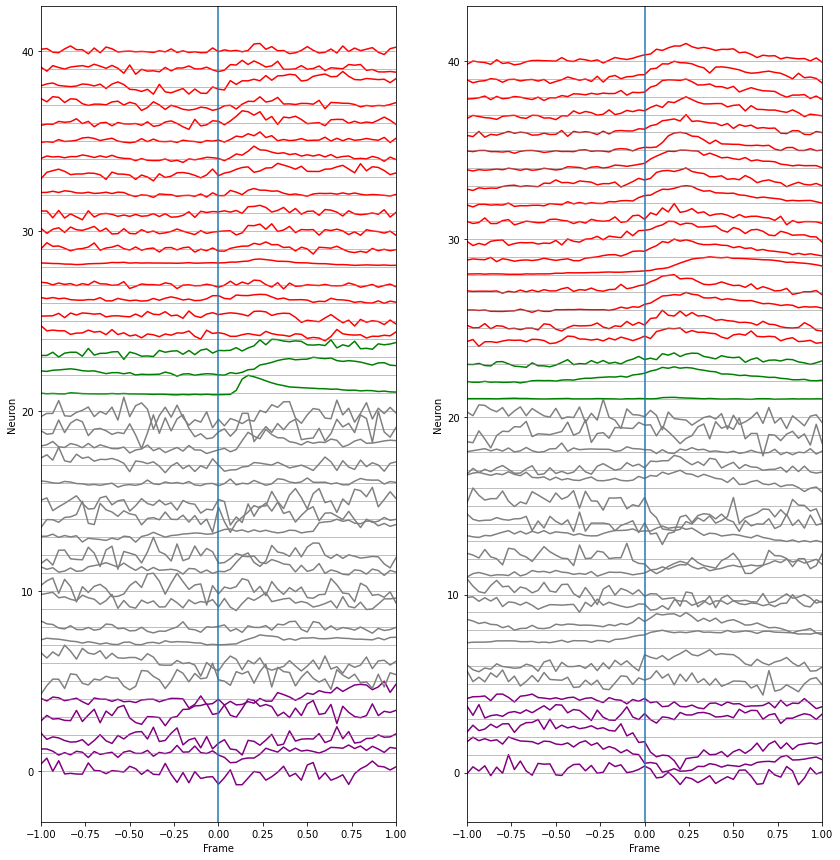

In [240]:
fig, axs = plt.subplots(figsize=(14, 15), ncols=2, facecolor="white")
# ax.yaxis.set_inverted(True)

colors = {
    -1: "purple",
    0: "gray",
    1: "green",
    2: "blue",
    3: "red"
}

r = 30
xaxis = np.arange(-r, r+1) / 30

print(pd.value_counts([get_saccade_magnitude_direction(data["eye_tracking"], *s)[1] for s in data["saccades"]]))

# for plot_index, roi in enumerate(range(len(response_classifications))):
for plot_index, roi in enumerate(np.argsort(response_classifications)):
    rc = response_classifications[roi]
    mean_saccade_response_pref = np.zeros_like(xaxis, dtype=dff.dtype)
    mean_saccade_response_notpref = np.zeros_like(xaxis, dtype=dff.dtype)
    n_sacc_pref = 0
    n_sacc_notpref = 0

    for i, (ss, se) in enumerate(data["saccades"]):
        mag, dir = get_saccade_magnitude_direction(data["eye_tracking"], ss, se)

        # Preferred direction
        # if (rc == -1) or (rc == 0) or (rc == 1) or (rc == 2 and dir == "L") or (rc == 3 and dir == "R"):
        if dir == "L":
            mean_saccade_response_pref += dff[roi, ss-r:ss+r+1]
            n_sacc_pref += 1
        
        # Not preferred direction
        # if (rc == -1) or (rc == 0) or (rc == 1) or (rc == 2 and dir == "R") or (rc == 3 and dir == "L"):
        if dir == "R":
            mean_saccade_response_notpref += dff[roi, ss-r:ss+r+1]
            n_sacc_notpref += 1
    
    mean_saccade_response_pref /= max(1, n_sacc_pref)
    mean_saccade_response_notpref /= max(1, n_sacc_notpref)
    scale = max(mean_saccade_response_pref.max(), mean_saccade_response_notpref.max())
    # mean_saccade_response_pref /= mean_saccade_response_pref.max()
    # mean_saccade_response_notpref /= mean_saccade_response_notpref.max()
    mean_saccade_response_pref /= scale
    mean_saccade_response_notpref /= scale

    axs[0].plot(xaxis, plot_index+mean_saccade_response_pref, color=colors[rc])
    axs[0].axhline(y=plot_index, color="gray", linestyle="solid", linewidth=0.5)
    axs[1].plot(xaxis, plot_index+mean_saccade_response_notpref, color=colors[rc])
    axs[1].axhline(y=plot_index, color="gray", linestyle="solid", linewidth=0.5)

for ax in axs:
    for ss, se in data["saccades"]:
        if start < ss and se < end:
            ax.axvspan(xmin=ss, xmax=se, color="gray", alpha=0.3)

    ax.set_xlim(xaxis.min(), xaxis.max())
    ax.axvline(x=0)
    ax.set_xlabel("Frame")
    ax.set_ylabel("Neuron")

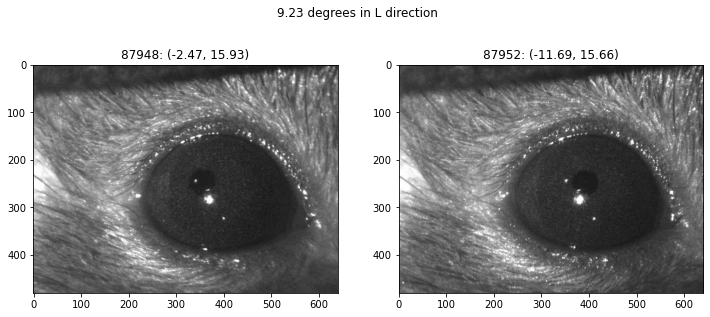

In [224]:
fig, axs = plt.subplots(figsize=(12, 5), ncols=2, facecolor="white")
saccade = random.choice(data["saccades"])

for ax, frame in zip(axs, saccade):
    x = data["eye_tracking"].loc[frame, "x_pos_deg"]
    y = data["eye_tracking"].loc[frame, "y_pos_deg"]

    vid_frame = twop_frame_to_vid_frame[frame]
    eye_movie.set(cv2.CAP_PROP_POS_FRAMES, vid_frame-1)
    flag, image = eye_movie.read()
    ax.imshow(image)

    ax.set_title(f"{frame}: ({x:.2f}, {y:.2f})")

mag, dir = get_saccade_magnitude_direction(data["eye_tracking"], *saccade)
fig.suptitle(f"{mag:.2f} degrees in {dir} direction")
vid_frame = twop_frame_to_vid_frame[frame]
eye_movie.set(cv2.CAP_PROP_POS_FRAMES, vid_frame-1)
flag, image = eye_movie.read()
ax_eyevid.imshow(image)